## Objective

### Load Packages

In [1]:
%matplotlib inline
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import get_file

### Load Sample Image

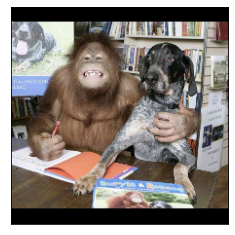

In [10]:
fpath = get_file("gradcam_sample.png",
"https://craftsangjae.s3.ap-northeast-2.amazonaws.com/images/gradcam_sample.png")
image = cv2.imread(fpath)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.xticks([]); plt.yticks([]);
plt.show()

## Guided Back propagation
---

![Imgur](https://i.imgur.com/pTzarAO.png)

In [11]:
import tensorflow as tf
from tensorflow.keras.activations import relu
from tensorflow.keras.utils import get_custom_objects

@tf.custom_gradient
def guidedrelu(x):
    a = tf.maximum(x,0.)
    def grad(dy):
        relu_mask = tf.cast(x > 0., tf.float32)
        guided_mask = tf.cast(dy > 0., tf.float32)
        return dy * guided_mask * relu_mask
    return a, grad

get_custom_objects().update({'relu':guidedrelu})

### Load Model

In [12]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

model = ResNet50V2()

### Get guided map 

In [13]:
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.models import Model

prep_image = preprocess_input(image)
prep_image = tf.constant(prep_image, tf.float32)
prep_image = prep_image

fmap = model.get_layer('post_relu').output
output = model.layers[-1].output

with tf.GradientTape() as tape:
    tape.watch(prep_image)
    model_outputs = model(prep_image[None])
guided_map = tape.gradient(model_outputs, prep_image)

### Visualize guided map

In [14]:
def normalize_image(image):
    return cv2.normalize(image, None, 0, 255, 
                         cv2.NORM_MINMAX, dtype=0)

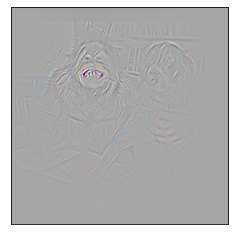

In [15]:
norm_image = normalize_image(guided_map.numpy())
plt.imshow(norm_image)
plt.xticks([]);plt.yticks([]);
plt.show()

## Grad CAM
---


### get sub ResNet50V2 for Calculating Gradient

In [21]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

model = ResNet50V2()

fmap = model.get_layer('post_relu').output
output = model.layers[-1].output

grad_model = Model(model.input, [fmap, output])

### Calculate Gradient-CAM 

In [22]:
def get_gradcam_result(image):
    global grad_model
    image = tf.constant(image)
    with tf.GradientTape() as tape:
        conv_outputs, model_outputs = grad_model(image[None])
        
        top_indices = tf.argmax(model_outputs, axis=1)
        top_logit = tf.gather(model_outputs, top_indices, axis=1)

    grads = tape.gradient(top_logit, conv_outputs)
    channel_importance = tf.reduce_mean(grads, axis=[1,2],
                                        keepdims=True)
    heat_map = tf.reduce_sum(channel_importance * conv_outputs, 
                             axis=-1, keepdims=True)
    heat_map = tf.nn.relu(heat_map)
    heat_map = tf.image.resize(heat_map, image.shape[:2])
    
    return tf.squeeze(heat_map).numpy()

In [23]:
cam_map = get_gradcam_result(prep_image)

### Visualize HeatMap

In [24]:
def blend_heatmap(image, heatmap, ratio=0.5):
    h, w = image.shape[:2]
    heatmap = cv2.resize(heatmap, (w, h))
    
    heatmap = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX, 0)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
    
    norm_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, 0)
    return cv2.addWeighted(heatmap, ratio, norm_image, 1-ratio, 1.)

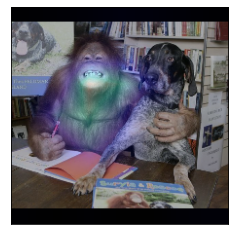

In [25]:
plt.imshow(blend_heatmap(image, cam_map, ratio=0.3))
plt.xticks([]);plt.yticks([]);
plt.show()